In [ ]:
"""
Reproduction of Tomi Vuoriheimo et al 2020 Phys. Scr. 2020 014056
"""

import numpy as np
import ufl
import h_transport_materials as htm
import festim as F


my_model = F.HydrogenTransportProblem()

thickness = 1e-3  # m
my_model.mesh = F.Mesh1D(
    vertices=np.concatenate(
        [
            np.linspace(0, 200e-9, num=300),
            np.linspace(200e-9, 1e-6, num=200),
            np.linspace(1e-6, thickness, num=200),
        ]
    )
)

H = F.Species("H")
D = F.Species("D")
trapped_H = F.Species("trapped_H", mobile=False)
trapped_D = F.Species("trapped_D", mobile=False)
my_model.species = [H, trapped_H]

tungsten_diff = htm.diffusivities.filter(material=htm.TUNGSTEN).mean()
tungsten = F.Material(
    name="tungsten",
    D_0=tungsten_diff.pre_exp.magnitude,
    E_D=tungsten_diff.act_energy.magnitude,
)

tungsten_subdomain = F.VolumeSubdomain1D(
    id=1, material=tungsten, borders=[0, thickness]
)
my_model.subdomains = [tungsten_subdomain]

fluence = 1.0e21  # H/m^2
flux_value = 6.2e16  # H/m^2/s

exposure_time = fluence / flux_value

flux = lambda t: ufl.conditional(ufl.lt(t, exposure_time), flux_value, 0)
distribution_ufl = lambda x: ufl.conditional(ufl.lt(x[0], 150e-9), 1/150e-9, 0)  # m^-1


def gaussian(x, mu, sigma):
    return 1 / (sigma * ufl.sqrt(2 * ufl.pi)) * ufl.exp(-0.5 * ((x - mu) / sigma) ** 2)


my_model.sources = [
    F.ParticleSource(
        value=lambda x, t: gaussian(x[0], mu=40e-9, sigma=2e-9) * flux(t),
        species=H,
        volume=tungsten_subdomain,
    )
]
annealing_temp = 25 + 273.15
exposure_temp = 25 + 273.15
annealing_time = 4 * 3600  # 4 hours
my_model.temperature = lambda t: exposure_temp if t < exposure_time else annealing_temp

n_vacancies = 1.7e21 # vacancies/m2

empty_trap = F.ImplicitSpecies(
    n=lambda x: distribution_ufl(x) * n_vacancies,
    others=[trapped_H],
)

w_atom_density = 6.3e28  # atom/m3
my_model.reactions = [
    F.Reaction(
        reactant=[H, empty_trap],
        product=[trapped_H],
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=1.2,
        volume=tungsten_subdomain,
    )
]

left = F.SurfaceSubdomain1D(id=1, x=0)
right = F.SurfaceSubdomain1D(id=2, x=thickness)
my_model.boundary_conditions = [
    F.FixedConcentrationBC(subdomain=left, species=H, value=0),
    F.FixedConcentrationBC(subdomain=right, species=H, value=0),
]

total_H = F.TotalVolume(field=trapped_H, volume=tungsten_subdomain)
my_model.exports = [
    total_H,
    F.VTXSpeciesExport(filename="H.bp", field=H),
    F.VTXSpeciesExport(filename="H_trapped.bp", field=trapped_H),
]

my_model.settings = F.Settings(
    atol=1e10,
    rtol=1e-10,
    final_time=annealing_time + exposure_time,
)

my_model.settings.stepsize = F.Stepsize(
    0.001,
    growth_factor=1.1,
    target_nb_iterations=4,
    cutback_factor=0.9,
    milestones=[exposure_time],
    max_stepsize=lambda t: None if t < exposure_time else 50,
)

from dolfinx.log import set_log_level, LogLevel

# set_log_level(LogLevel.INFO)

my_model.initialise()

print(my_model.formulation)


my_model.run()

{ ({ A | A_{i_{160}} = (grad(f[0]))[i_{160}] * c_77 * exp(-1 * c_78 / 8.6173303e-05 / c_74) }) . (grad(v_0[0])) } * dx(<Mesh #8>[1], {})
  +  { v_0[0] * (f[0] + -1 * f[0]) / c_73 } * dx(<Mesh #8>[1], {})
  +  { v_0[1] * (f[1] + -1 * f[1]) / c_73 } * dx(<Mesh #8>[1], {})
  +  { v_0[0] * (-1 * f[1] * 10000000000000.0 * exp(-1.2 / 8.6173303e-05 * c_74) + f[0] * (-1 * f[1] + 1.7e+21 * (((x[0]) < (1.5e-07)) ? (6666666.666666667) : (0))) * 1.948749409185342e-16 * exp(-0.5938514765852969 / 8.6173303e-05 * c_74)) } * dx(<Mesh #8>[1], {})
  +  { v_0[1] * -1 * (-1 * f[1] * 10000000000000.0 * exp(-1.2 / 8.6173303e-05 * c_74) + f[0] * (-1 * f[1] + 1.7e+21 * (((x[0]) < (1.5e-07)) ? (6666666.666666667) : (0))) * 1.948749409185342e-16 * exp(-0.5938514765852969 / 8.6173303e-05 * c_74)) } * dx(<Mesh #8>[1], {})
  +  { -1 * v_0[0] * 199471140.20071635 * exp(-0.5 * ((-4e-08 + x[0]) / 2e-09) ** 2) * (((c_72) < (16129.032258064517)) ? (6.2e+16) : (0)) } * dx(<Mesh #8>[1], {})


Solving HydrogenTransportProblem: 100%|██████████| 30.5k/30.5k [00:02<00:00, 11.8kit/s] 


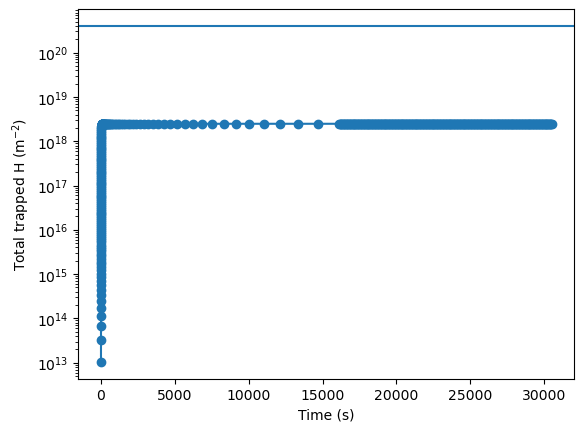

In [20]:
import matplotlib.pyplot as plt

plt.plot(total_H.t, total_H.data, marker="o")
plt.xlabel("Time (s)")
plt.ylabel("Total trapped H (m$^{-2}$)")
plt.axhline(40e19)
plt.yscale("log")
plt.show()